# Model

In [0]:
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D, concatenate, Reshape, MaxPooling2D, Flatten
from keras import regularizers
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import model_from_json

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [0]:
input_shape = [300, 300, 3]
num_of_classes = 21
l2_penalty = 1e-8

In [0]:
def vgg_weights(input_shape, num_of_classes):
  
  vgg = VGG16(input_shape = input_shape, classes = num_of_classes, include_top = False)
  
  vgg_weights = []
  
  for layer in vgg.layers:
    vgg_weights.append(layer.get_weights())
   
  return vgg_weights

In [0]:
weights = vgg_weights(input_shape, num_of_classes)[1: -1]

In [0]:
def set_weights(weights, model):
  
  i = 0
  
  for layer in model.layers:
    layer.set_weights(weights[i])
    # layer.trainable = False        (Not use because SSD is not transfer learning but fine tuning)
    i += 1
   
  return model

In [0]:
def output_list(model):
  layer_name_to_use = ['Conv4_3', 'Conv7', 'Conv8_2', 'Conv9_2', 'Conv10_2', 'Conv11_2']
  output_list = []
  
  for layer in model.layers:
    if layer.name in layer_name_to_use:
      output_list.append(layer.output)
      
  return output_list

In [0]:
def model(input_shape, weights, l2_penalty):
  model = Sequential()
  
  "Conv Layers"
  model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu', input_shape = input_shape, name = 'Conv1_1'))
  model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'Conv1_2'))
  model.add(MaxPooling2D(name = 'Pool_1', padding = 'same'))
  
  model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'Conv2_1'))
  model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'Conv2_2'))
  model.add(MaxPooling2D(name = 'Pool_2', padding = 'same'))
  
  model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'Conv3_1'))
  model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'Conv3_2'))
  model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'Conv3_3'))
  model.add(MaxPooling2D(name = 'Pool_3', padding = 'same'))
  
  model.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'Conv4_1'))
  model.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'Conv4_2'))
  model.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'Conv4_3'))
  model.add(MaxPooling2D(name = 'Pool_4', padding = 'same'))
  
  model.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'Conv5_1'))
  model.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'Conv5_2'))
  model.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'Conv5_3'))
  
  
  "Set Weights of Pre-trained VGG16"
  model = set_weights(weights, model)
  
  
  model.add(Conv2D(filters = 1024, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'Conv6'))
  
  model.add(Conv2D(filters = 1024, kernel_size = (1, 1), padding = 'same', activation = 'relu', name = 'Conv7'))
  
  model.add(Conv2D(filters = 256, kernel_size = (1, 1), padding = 'same', activation = 'relu', name = 'Conv8_1'))
  model.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = 'same', activation = 'relu', strides = (2, 2), name = 'Conv8_2'))
 
  model.add(Conv2D(filters = 128, kernel_size = (1, 1), padding = 'same', activation = 'relu', name = 'Conv9_1'))
  model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'relu', strides = (2, 2), name = 'Conv9_2'))
  
  model.add(Conv2D(filters = 128, kernel_size = (1, 1), padding = 'same', activation = 'relu', name = 'Conv10_1'))
  model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = 'valid', activation = 'relu', strides = (1, 1), name = 'Conv10_2'))
  
  model.add(Conv2D(filters = 128, kernel_size = (1, 1), padding = 'same', activation = 'relu', name = 'Conv11_1'))
  model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = 'valid', activation = 'relu', strides = (1, 1), name = 'Conv11_2'))
  
  
  
  
  "Extra Feature Layers"
  output = output_list(model)
  
  clf_1 = Conv2D(filters = 4 * num_of_classes, kernel_size = (3, 3), padding = 'same', kernel_regularizer = regularizers.l2(l2_penalty), name = 'clf_1')(output[0])
  rgs_1 = Conv2D(filters = 4 * 4, kernel_size = (3, 3), padding = 'same', kernel_regularizer = regularizers.l2(l2_penalty), name = 'rgs_1')(output[0])
  
  clf_2 = Conv2D(filters = 6 * num_of_classes, kernel_size = (3, 3), padding = 'same', name = 'clf_2')(output[1])
  rgs_2 = Conv2D(filters = 6 * 4, kernel_size = (3, 3), padding = 'same', name = 'rgs_2')(output[1])
  
  clf_3 = Conv2D(filters = 6 * num_of_classes, kernel_size = (3, 3), padding = 'same', name = 'clf_3')(output[2])
  rgs_3 = Conv2D(filters = 6 * 4, kernel_size = (3, 3), padding = 'same', name = 'rgs_3')(output[2])
  
  clf_4 = Conv2D(filters = 6 * num_of_classes, kernel_size = (3, 3), padding = 'same', name = 'clf_4')(output[3])
  rgs_4 = Conv2D(filters = 6 * 4, kernel_size = (3, 3), padding = 'same', name = 'rgs_4')(output[3])
  
  clf_5 = Conv2D(filters = 4 * num_of_classes, kernel_size = (3, 3), padding = 'same', name = 'clf_5')(output[4])
  rgs_5 = Conv2D(filters = 4 * 4, kernel_size = (3, 3), padding = 'same', name = 'rgs_5')(output[4])
  
  clf_6 = Conv2D(filters = 4 * num_of_classes, kernel_size = (3, 3), padding = 'same', name = 'clf_6')(output[5])
  rgs_6 = Conv2D(filters = 4 * 4, kernel_size = (3, 3), padding = 'same', name = 'rgs_6')(output[5])
  
  
  fl_1 = Flatten(name = 'fl_1')(clf_1)
  fl_2 = Flatten(name = 'fl_2')(clf_2)
  fl_3 = Flatten(name = 'fl_3')(clf_3)
  fl_4 = Flatten(name = 'fl_4')(clf_4)
  fl_5 = Flatten(name = 'fl_5')(clf_5)
  fl_6 = Flatten(name = 'fl_6')(clf_6)
  clf = concatenate([fl_1, fl_2, fl_3, fl_4, fl_5, fl_6], axis = 1, name = 'clf')
  clf_reshaped = Reshape((-1, 21), name = 'clf_reshaped')(clf)
  
  fl_7 = Flatten(name = 'fl_7')(rgs_1)
  fl_8 = Flatten(name = 'fl_8')(rgs_2)
  fl_9 = Flatten(name = 'fl_9')(rgs_3)
  fl_10 = Flatten(name = 'fl_10')(rgs_4)
  fl_11 = Flatten(name = 'fl_11')(rgs_5)
  fl_12 = Flatten(name = 'fl_12')(rgs_6)
  rgs = concatenate([fl_7, fl_8, fl_9, fl_10, fl_11, fl_12], axis = 1, name = 'rgs')
  rgs_reshaped = Reshape((-1, 4), name = 'rgs_reshaped')(rgs)
  
  concat = concatenate([clf_reshaped, rgs_reshaped], axis = 2, name = 'model') 
  
  ssd_model = Model(inputs = model.input, outputs = concat)
  
  return ssd_model

In [0]:
model = model(input_shape, weights, l2_penalty)

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Conv1_1_input (InputLayer)      (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
Conv1_1 (Conv2D)                (None, 300, 300, 64) 1792        Conv1_1_input[0][0]              
__________________________________________________________________________________________________
Conv1_2 (Conv2D)                (None, 300, 300, 64) 36928       Conv1_1[0][0]                    
__________________________________________________________________________________________________
Pool_1 (MaxPooling2D)           (None, 150, 150, 64) 0           Conv1_2[0][0]                    
__________________________________________________________________________________________________
Conv2_1 (C

#Default Box

In [0]:
from itertools import product as product

In [0]:
def default_box_maker():
  
  # Information to use
  m_list = [3, 5, 5, 5, 3, 3]
  feature_maps = [38, 19, 10, 5, 3, 1]
  shrinkage = [8, 16, 32, 64, 100, 300]
  aspect_ratio = [[2], [2, 3], [2, 3], [2, 3], [2], [2]]
  image_size = 300

  min_sizes = [30, 60, 111, 162, 213, 264]
  max_sizes = [60, 111, 162, 213, 264, 315]
  
  # coordinates of default box which are relative to each cell
  coordinate = []

  for index, feature_size in enumerate(feature_maps):
    m = m_list[index]
    f_k = image_size / shrinkage[index]
  
    for i, j in product(range(feature_size), repeat = 2):
    
      cx = (i + 0.5) / f_k
      cy = (j + 0.5) / f_k
    
      s_k = min_sizes[index] / image_size
      s_k_prime = (s_k * max_sizes[index] / image_size) ** (0.5)
      
      coordinate.append([cx, cy, s_k, s_k])
      coordinate.append([cx, cy, s_k_prime, s_k_prime])
      
      for a_r in aspect_ratio[index]:
        
        root_a_r = (a_r) ** 0.5
        
        coordinate.append([cx, cy, s_k * root_a_r, s_k / root_a_r])
        coordinate.append([cx, cy, s_k / root_a_r, s_k * root_a_r])
      
  coordinate = np.array(coordinate)
  coordinate = np.clip(coordinate, 0.0, 1.0)                         # Set the coordinates between 0.0 and 1.0
  
  return coordinate

In [12]:
coordinate = default_box_maker()
coordinate.shape

(8732, 4)

# IoU

In [0]:
# https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

def bb_intersection_over_union(boxA, boxB):
  xA = max(boxA[0], boxB[0])
  yA = max(boxA[1], boxB[1])
  xB = min(boxA[2], boxB[2])
  yB = min(boxA[3], boxB[3])
  
  interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
  
  boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
  boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
  
  iou = interArea / float(boxAArea + boxBArea - interArea)
  
  return iou

In [0]:
import xml.etree.ElementTree as ET

In [0]:
def annotation(file_path):
  
  tree = ET.parse(file_path)
  root = tree.getroot()
  root.get('object')
  
  
  # Image Size
  
  image_size = []

  for image_info in root[4]:
    image_size.append(int(image_info.text))
    
  
  
  # Coordinates of GT Box
  gt_box = []
  
  for object in root[6:]:
    gt_box.append([object[0].text,                         # Object label
                   int(object[4][0].text), # xmin
                   int(object[4][1].text), # ymin
                   int(object[4][2].text), # xmax
                   int(object[4][3].text)  # ymax
                  ])
  
  return image_size, gt_box

# Dataset

In [16]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [17]:
cd /gdrive/My \Drive/

/gdrive/My Drive


In [0]:
def data_name_list(txt_path, data_path, format):
  'format : .xml or .jp*g'
  
  reader = open(txt_path)
  txt = reader.read()
  txt_list = txt.split('\n')
  
  for i in range(len(txt_list)):
    txt_list[i] = data_path + txt_list[i] + format
  
  del txt_list[-1]
  
  return txt_list

In [0]:
# 'train.txt' contains the name of train images.

xml_files = data_name_list('train.txt', 'Annotations/', '.xml')
image_files = data_name_list('train.txt', 'JPEGImages/', '.jpg')

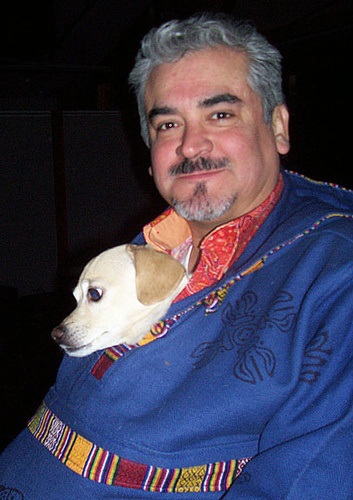

In [33]:
# Image Example

image.load_img('JPEGImages.zip (Unzipped Files)/000001.jpg')

In [0]:
label_list = ['background', 'person', 'bird', 'cat', 'cow', 'dog', 'horse', 'sheep', 'aeroplane', 'bicycle', 'boat', 'bus', 'car', 'motorbike', 'train', 'bottle', 'chair', 'diningtable', 'pottedplant', 'sofa', 'tvmonitor']

In [35]:
print("Number of Label :", len(label_list))

Number of Label : 21


In [0]:
def coordinate_to_xy(coordinate, image_size):
  
  coordinate_xy = []
  
  width = image_size[0]
  height = image_size[1]

  
  for point in coordinate:
    xmin = np.clip((point[0] - point[3]/2) * width, 0.0, width)
    ymin = np.clip((point[1] - point[2]/2) *  height, 0.0, height)
    xmax = np.clip((point[0] + point[3]/2) * width, 0.0, width)
    ymax = np.clip((point[1] + point[2]/2) * height, 0.0, height)
    coordinate_xy.append([xmin, ymin, xmax, ymax])

  coordinate_xy = np.array(coordinate_xy)
  
  return coordinate_xy

In [0]:
def box_matching(coordinate, coordinate_xy, gt_box, label_list, threshold = 0.5):
  
  zero_list = list(np.zeros([21]))
  zero_list[0] = 1
  background_array = np.array(zero_list * 8732).reshape(-1, 21)
  data_array = np.concatenate([background_array, coordinate], axis = 1)
  
  

  for object_info in gt_box:
    name = object_info[0]
    index = label_list.index(name)
    
    object_coordinate = object_info[1:]
    
    for i in range(8732):
      bb_iou = bb_intersection_over_union(coordinate_xy[i], object_coordinate)
      
      if threshold < bb_iou:
        data_array[i][0] = 0
        data_array[i][index] = 1
 
  return data_array

In [0]:
# Matching default box with GT box

matched_box = []
error_file = []

for xml_file in xml_files:
  try:
    image_size, gt_box = annotation(xml_file)
    coordinate_xy = coordinate_to_xy(coordinate, image_size)
    matched_box.append(box_matching(coordinate, coordinate_xy, gt_box, label_list))
    
  except ValueError:
    error_file.append(xml_file)
    print(xml_file + " : ValueError")
  
matched_box = np.array(matched_box)

In [0]:
for filename in error_file:
  del image_files[image_files.index('JPEGImages' + filename[10:-3] + 'jpg')]

In [0]:
# Input data

train_image = []

for image_path in image_files:
  image_array = image.img_to_array(Image.open(image_path).resize((300, 300)))
  train_image.append(image_array)
  
train_image = np.array(train_image)

In [0]:
# Save data to npy file

np.save('train_image.npy', train_image)
np.save('matched_box.npy', matched_box)

In [0]:
# Load data

X_train = np.load('train_image.npy')
y_train = np.load('matched_box.npy')

# Loss Function

In [53]:
cd /gdrive/My \Drive/keras_loss_function

/gdrive/My Drive/keras_loss_function


In [0]:
# https://github.com/pierluigiferrari/ssd_keras

from keras_ssd_loss import SSDLoss

In [0]:
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

# Training

In [0]:
model.compile(optimizer = 'adam', loss = ssd_loss.compute_loss)

In [0]:
r = model.fit(X_train, y_train, epochs = 50)

# Save model to json file

In [0]:
model_json = model.to_json()

In [58]:
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
